## No Credit Data
---

We didn't/cannot reasonably enforce monotonicity when the model is lacking a significant amount of credit data. Let's take a look on how the model bahaves when such situation occurs.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../..')
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from tqdm import tqdm
import copy

from src.utils import scale_scores
from rdsutils.lightgbm_helpers import train_lgb_baseline_grouped
from rdsutils.post_implementation_testing import plot_score_dist, get_psi, get_overlap_and_diff
from rdsutils.post_implementation_testing import plot_difference, get_combined_dfs, get_feature_comparison_report

In [2]:
with open('../../models/customer_risk_target_no_giact_time_since_last_link.pkl', 'rb') as f:
    model = pickle.load(f)

### Data Processing
---

In [3]:
from utils import preprocess

In [4]:
# test_df = pd.read_feather('../../artifacts/oot_unscored_2020-04-15.feather')
s3_path = "s3://sofi-data-science/jxu/money-risk-models/customer-risk-model/data/20210103/combined_1609721645.feather"
test_df = pd.read_feather(s3_path)

In [5]:
last_date = test_df.sample_date.max()
display(last_date)
test_df = test_df[test_df.sample_date == last_date]

Timestamp('2020-11-01 00:00:00')

In [6]:
test_df.head()

,transaction_datetime,borrower_id,business_account_number,transaction_code,transaction_amount,external_account_number,real_ending_balance,user_id,sofi_employee_ind,dtc,...,last_unrestricted_date_in_next_90d,latest_acc_bal,is_chg_wrt_off_in_90d,nr_returns_in_next_90d,bal_after_90d,target,target_with_restriction,indeterminate,sample_date,is_static
3613683,2019-06-17 18:01:13,44.0,410000434669,ACHDW,-10.09,1023025883,0.00,188,False,None,...,False,0.00,False,0.0,0.00,False,False,True,2020-11-01,True
3613684,2020-04-28 04:46:22,103.0,410002729647,ACHDWIN,-0.65,,1106.44,299,False,None,...,True,1106.44,False,0.0,1106.44,False,False,True,2020-11-01,True
3613685,NaT,11007682.0,410009278215,None,NaN,None,NaN,17177836,False,None,...,False,NaN,False,0.0,NaN,False,False,True,2020-11-01,True
3613686,2020-10-31 07:59:50,90.0,410001537288,POSDW,-71.99,,159741.26,273,False,None,...,False,175836.93,False,0.0,175836.93,False,False,True,2020-11-01,True
3613687,2020-10-30 04:06:57,40.0,410000178332,ACHINDD,1551.00,,3542.60,195,False,None,...,False,2453.28,False,0.0,2453.28,False,False,True,2020-11-01,True


In [7]:
test_df.shape

(500936, 106)

### Map over Credit Features
---

In [8]:
L = """# vantage_score
# all7120
# all8220
# bcc7120
# iln5520
# iqt9415
# credit_card_loan_amount
# education_loan_amount
# total_tradelines_open
# iqt9413""".split()
credit_features = list(filter(lambda l:len(l)>1, L))

In [9]:
def encode_as_missing(df, features):
    "return a copy of df with provided features masked with np.nan"
    df_ = df.copy(deep=True)
    df_[features] = np.nan
    return df_



In [10]:
# drop the rows that already have all credit missing
df_test = test_df
df_test = df_test[~df_test[credit_features].isna().all(axis=1)]
df_missing = encode_as_missing(df_test, credit_features)

In [11]:
df_test.shape, df_missing.shape

((483286, 106), (483286, 106))

### Evaluation
---

In [12]:
def scale_scores(predictions):
    """
    Convert probability to score.
    """
    try:
        assert ((predictions >= 0) & (predictions <= 1)).all(), 'probability must be in range [0,1]'
    except AssertionError:
        raise

    # Formula parameters
    ALPHA = 631.9455383610933
    BETA = 30.812519272450654

    # Minimum and maximum values for validation
    MINIMUM = 300
    MAXIMUM = 850

    score = np.minimum(np.maximum(np.log(predictions / (1 - predictions)) * BETA + ALPHA, MINIMUM), MAXIMUM)
   
    return score

In [13]:
# update risk groups
# if splits needed: RG3 splits at 530, RG4 at 580

def get_risk_groups(serie):
    return pd.cut(serie.round(), [300, 474, 510, 560, 600, 850], 
                  right=True, labels=[f'RG{i}' for i in range(1, 6)])

### Original Data

In [14]:
features = model.feature_name_

In [15]:
features = model.feature_name_
df_test = preprocess(df_test)
df_test.head()

,transaction_datetime,borrower_id,business_account_number,transaction_code,transaction_amount,external_account_number,real_ending_balance,user_id,sofi_employee_ind,dtc,...,nr_returns_in_next_90d,bal_after_90d,target,target_with_restriction,indeterminate,sample_date,is_static,transaction_code_encoded,all7120_default_encoded,bcc7120_default_encoded
3613683,2019-06-17 18:01:13,44.0,410000434669,ACHDW,-10.09,1023025883,0.00,188,False,None,...,0.0,0.00,False,False,True,2020-11-01,True,5,-1.0,-1.0
3613684,2020-04-28 04:46:22,103.0,410002729647,ACHDWIN,-0.65,,1106.44,299,False,None,...,0.0,1106.44,False,False,True,2020-11-01,True,3,-1.0,-1.0
3613686,2020-10-31 07:59:50,90.0,410001537288,POSDW,-71.99,,159741.26,273,False,None,...,0.0,175836.93,False,False,True,2020-11-01,True,1,-1.0,-1.0
3613693,2019-08-19 18:01:10,141409.0,410002292642,ACHDD,3000.00,832597868,6000.00,505,False,None,...,0.0,6000.00,False,False,True,2020-11-01,True,2,-1.0,-1.0
3613694,2020-10-29 21:36:40,550.0,410001731014,DWTRF,-1739.68,,42788.92,513,False,None,...,0.0,55058.36,False,False,True,2020-11-01,True,0,-1.0,-1.0


In [16]:
df_test['pred'] = model.predict_proba(df_test[features])[:,1]
df_test['score'] = scale_scores(df_test['pred'])
df_test['risk_group'] = get_risk_groups(df_test.score)

### Masked Features

In [17]:
features = model.feature_name_
df_missing = preprocess(df_missing)
df_missing.head()

,transaction_datetime,borrower_id,business_account_number,transaction_code,transaction_amount,external_account_number,real_ending_balance,user_id,sofi_employee_ind,dtc,...,nr_returns_in_next_90d,bal_after_90d,target,target_with_restriction,indeterminate,sample_date,is_static,transaction_code_encoded,all7120_default_encoded,bcc7120_default_encoded
3613683,2019-06-17 18:01:13,44.0,410000434669,ACHDW,-10.09,1023025883,0.00,188,False,None,...,0.0,0.00,False,False,True,2020-11-01,True,5,-1.0,-1.0
3613684,2020-04-28 04:46:22,103.0,410002729647,ACHDWIN,-0.65,,1106.44,299,False,None,...,0.0,1106.44,False,False,True,2020-11-01,True,3,-1.0,-1.0
3613686,2020-10-31 07:59:50,90.0,410001537288,POSDW,-71.99,,159741.26,273,False,None,...,0.0,175836.93,False,False,True,2020-11-01,True,1,-1.0,-1.0
3613693,2019-08-19 18:01:10,141409.0,410002292642,ACHDD,3000.00,832597868,6000.00,505,False,None,...,0.0,6000.00,False,False,True,2020-11-01,True,2,-1.0,-1.0
3613694,2020-10-29 21:36:40,550.0,410001731014,DWTRF,-1739.68,,42788.92,513,False,None,...,0.0,55058.36,False,False,True,2020-11-01,True,0,-1.0,-1.0


In [18]:
df_missing['pred'] = model.predict_proba(df_missing[features])[:,1]
df_missing['score'] = scale_scores(df_missing['pred'])
df_missing['risk_group'] = get_risk_groups(df_missing.score)

### Score level Comparison

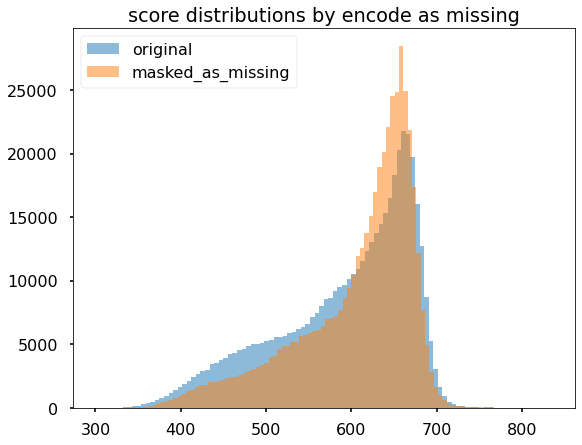

In [19]:
_ = plot_score_dist(df_test.score, df_missing.score,
                    dev_label="original", prod_label="masked_as_missing", 
                    bins=100, title="score distributions by encode as missing")

by encode as missing, model score generally moves up


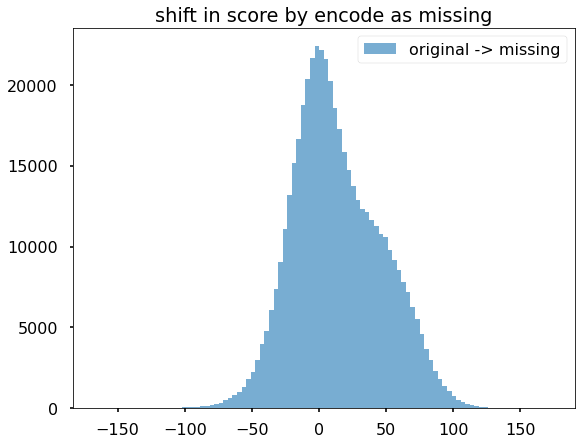

In [20]:
def plot_difference(expected_sequence, actual_sequence, 
                    figsize=(9,7), bins=10, label='exp - actual', title=''):
    """ Plot the distr of difference of two sequences 
    Two sequences should have the same size
    """
    assert(len(expected_sequence) == len(actual_sequence))
    fig = plt.figure(figsize=figsize)
    seq = np.array(expected_sequence) - np.array(actual_sequence)
    plt.hist(seq, alpha=0.6, bins=bins, label=label)
    plt.legend()
    plt.title(title)
    return fig

_ = plot_difference(df_missing.score, df_test.score,  
                    bins=100, label="original -> missing",
                    title="shift in score by encode as missing")
print("by encode as missing, model score generally moves up")

Text(0.5, 1.0, 'Risk Group distributions')

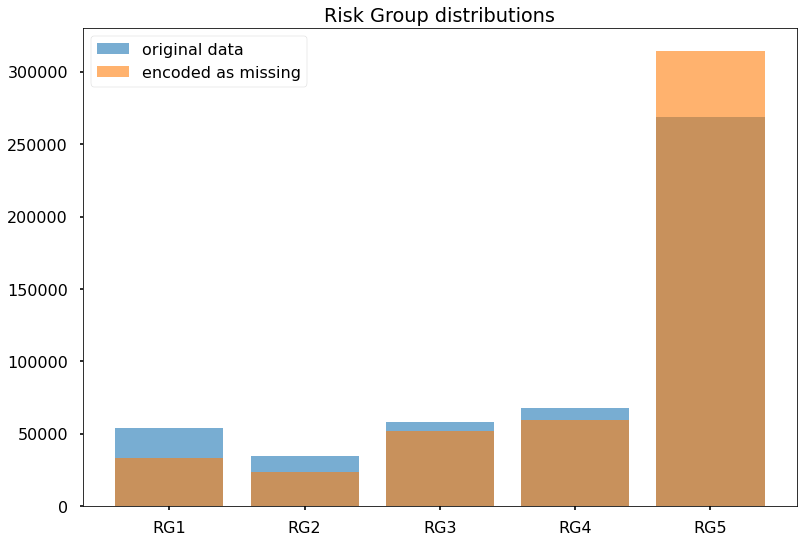

In [21]:
fig = plt.figure()
data = df_test.risk_group.value_counts().sort_index()
plt.bar(data.index, data.values, alpha=0.6, label='original data')
data = df_missing.risk_group.value_counts().sort_index()
plt.bar(data.index, data.values, alpha=0.6, label='encoded as missing')
plt.legend()
plt.title('Risk Group distributions')

Text(0.5, 1.0, 'Risk Group difference by encode credit features as missing')

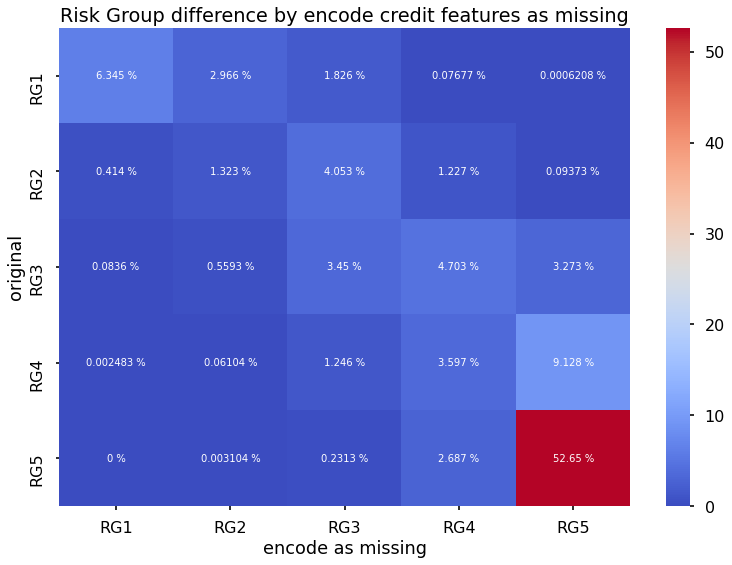

In [22]:
table = pd.merge(df_test[["business_account_number", "risk_group"]].astype(str),
                 df_missing[["business_account_number", "risk_group"]].astype(str),
                 on="business_account_number", suffixes=("_original", "_as_missing"),
                 how="inner")
table = table[["risk_group_original", "risk_group_as_missing"]].value_counts(normalize=True).sort_index().reset_index()

table.columns = ['original', 'encode as missing', 'counts']
table = pd.pivot_table(table, values='counts', index='original', 
                       columns='encode as missing', fill_value=0) * 100 # to percentage
fig = plt.figure()
ax = sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.4g')
for t in ax.texts: t.set_text(t.get_text() + " %")

plt.title('Risk Group difference by encode credit features as missing')

Text(0.5, 1.0, 'Risk Group difference by encode credit features as missing')

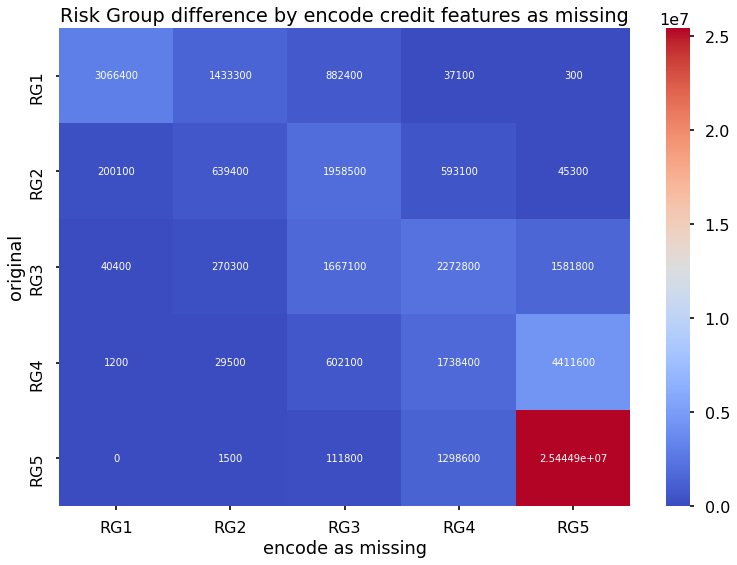

In [37]:
table = pd.merge(df_test[["business_account_number", "risk_group"]].astype(str),
                 df_missing[["business_account_number", "risk_group"]].astype(str),
                 on="business_account_number", suffixes=("_original", "_as_missing"),
                 how="inner")
table = table[["risk_group_original", "risk_group_as_missing"]].value_counts(normalize=False).sort_index().reset_index()

table.columns = ['original', 'encode as missing', 'counts']
table = pd.pivot_table(table, values='counts', index='original', 
                       columns='encode as missing', fill_value=0) * 100 # to percentage
fig = plt.figure()
ax = sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.7g')
plt.title('Risk Group difference by encode credit features as missing')

### New Accounts - Approximate by haven't initiated any transactions
---

Since this measure is more for onboarding, let's look into that sub-group.

In [23]:
df_test.head()

,transaction_datetime,borrower_id,business_account_number,transaction_code,transaction_amount,external_account_number,real_ending_balance,user_id,sofi_employee_ind,dtc,...,target_with_restriction,indeterminate,sample_date,is_static,transaction_code_encoded,all7120_default_encoded,bcc7120_default_encoded,pred,score,risk_group
3613683,2019-06-17 18:01:13,44.0,410000434669,ACHDW,-10.09,1023025883,0.00,188,False,None,...,False,True,2020-11-01,True,5,-1.0,-1.0,0.003040,453.451334,RG1
3613684,2020-04-28 04:46:22,103.0,410002729647,ACHDWIN,-0.65,,1106.44,299,False,None,...,False,True,2020-11-01,True,3,-1.0,-1.0,0.000785,411.674172,RG1
3613686,2020-10-31 07:59:50,90.0,410001537288,POSDW,-71.99,,159741.26,273,False,None,...,False,True,2020-11-01,True,1,-1.0,-1.0,0.003938,461.456265,RG1
3613693,2019-08-19 18:01:10,141409.0,410002292642,ACHDD,3000.00,832597868,6000.00,505,False,None,...,False,True,2020-11-01,True,2,-1.0,-1.0,0.000335,385.415717,RG1
3613694,2020-10-29 21:36:40,550.0,410001731014,DWTRF,-1739.68,,42788.92,513,False,None,...,False,True,2020-11-01,True,0,-1.0,-1.0,0.000521,399.046190,RG1


In [24]:
df_test.shape, df_missing.shape

((483286, 112), (483286, 112))

In [25]:
df_test.columns

Index(['transaction_datetime', 'borrower_id', 'business_account_number',
       'transaction_code', 'transaction_amount', 'external_account_number',
       'real_ending_balance', 'user_id', 'sofi_employee_ind', 'dtc',
       ...
       'target_with_restriction', 'indeterminate', 'sample_date', 'is_static',
       'transaction_code_encoded', 'all7120_default_encoded',
       'bcc7120_default_encoded', 'pred', 'score', 'risk_group'],
      dtype='object', length=112)

In [26]:
df_test[df_test.nr_past_transactions == 0].shape

(307175, 112)

In [27]:
df_test_new = df_test[df_test.nr_past_transactions == 0]
df_missing_new = df_missing[df_missing.nr_past_transactions == 0]

<AxesSubplot:>

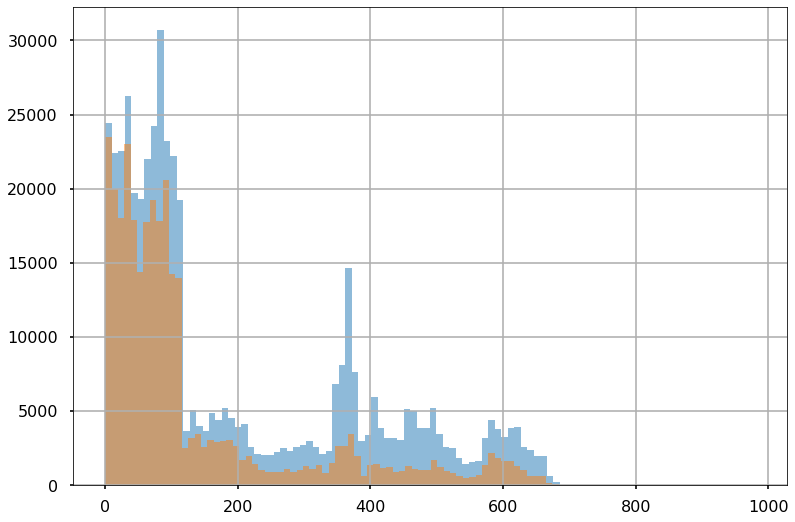

In [28]:
df_test.age_money_account.hist(bins=100, alpha=0.5)
df_test_new.age_money_account.hist(bins=100, alpha=0.5)

In [29]:
df_test_new.shape, df_missing_new.shape

((307175, 112), (307175, 112))

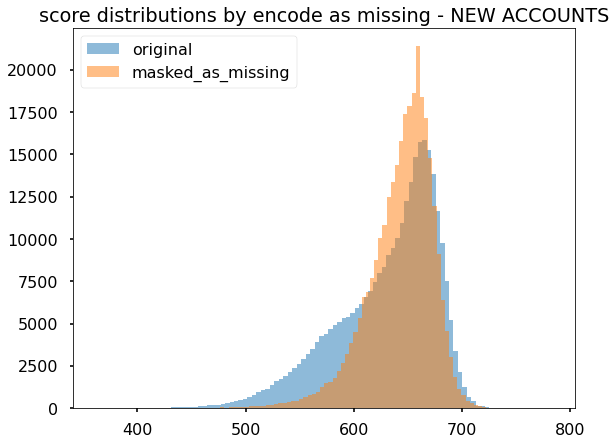

In [30]:
_ = plot_score_dist(df_test_new.score, df_missing_new.score,
                    dev_label="original", prod_label="masked_as_missing", 
                    bins=100, title="score distributions by encode as missing - NEW ACCOUNTS")

by encode as missing, model score generally moves up


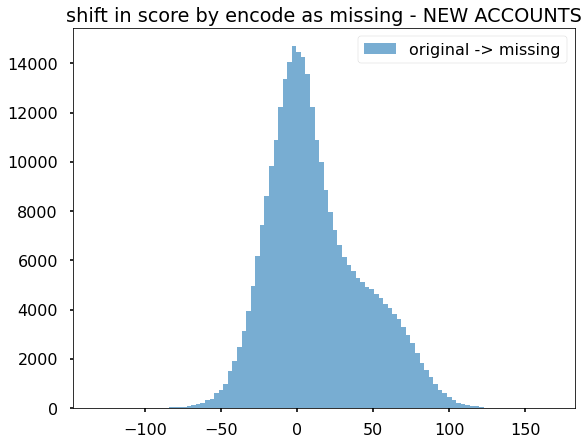

In [31]:
def plot_difference(expected_sequence, actual_sequence, 
                    figsize=(9,7), bins=10, label='exp - actual', title=''):
    """ Plot the distr of difference of two sequences 
    Two sequences should have the same size
    """
    assert(len(expected_sequence) == len(actual_sequence))
    fig = plt.figure(figsize=figsize)
    seq = np.array(expected_sequence) - np.array(actual_sequence)
    plt.hist(seq, alpha=0.6, bins=bins, label=label)
    plt.legend()
    plt.title(title)
    return fig

_ = plot_difference(df_missing_new.score, df_test_new.score,  
                    bins=100, label="original -> missing",
                    title="shift in score by encode as missing - NEW ACCOUNTS")
print("by encode as missing, model score generally moves up")

In [ ]:
def plot_difference(expected_sequence, actual_sequence, 
                    figsize=(9,7), bins=10, label='exp - actual', title=''):
    """ Plot the distr of difference of two sequences 
    Two sequences should have the same size
    """
    assert(len(expected_sequence) == len(actual_sequence))
    fig = plt.figure(figsize=figsize)
    seq = np.array(expected_sequence) - np.array(actual_sequence)
    plt.hist(seq, alpha=0.6, bins=bins, label=label)
    plt.legend()
    plt.title(title)
    return fig

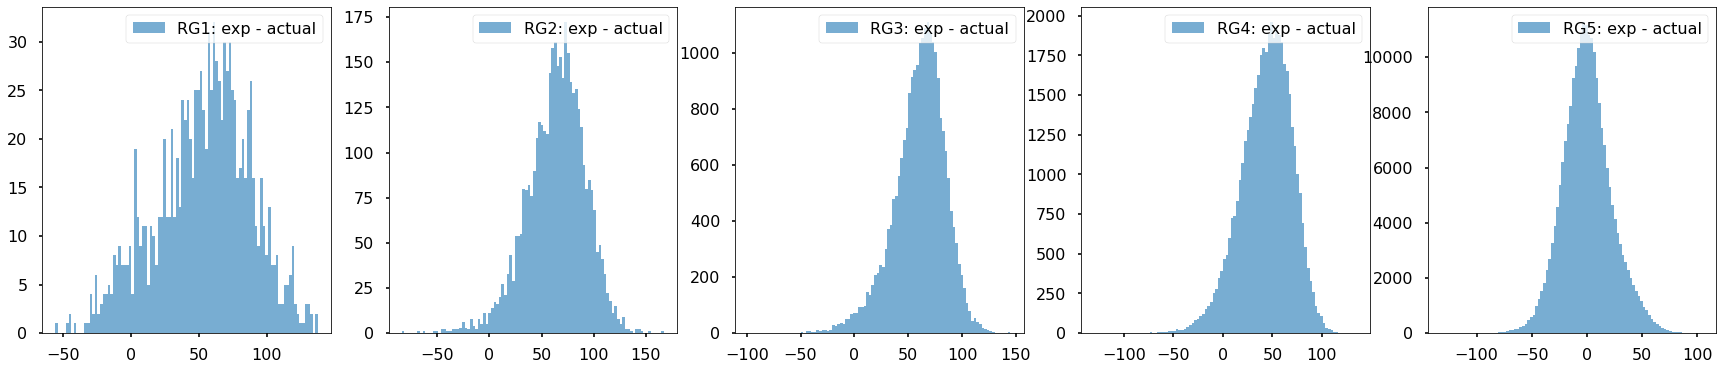

In [47]:
fig, axs = plt.subplots(1, 5, figsize=(30, 6))
for i, rg in enumerate(["RG1", "RG2", "RG3", "RG4", "RG5"]):
    exp_seq = df_missing_new[df_test_new.risk_group==rg].score
    act_seq = df_test_new[df_test_new.risk_group==rg].score
    seq = np.array(exp_seq) - np.array(act_seq)
    axs[i].hist(seq, alpha=0.6, bins=100, label=f'{rg}: exp - actual')
    axs[i].legend()

Text(0.5, 1.0, 'Risk Group distributions - NEW ACCOUNTS')

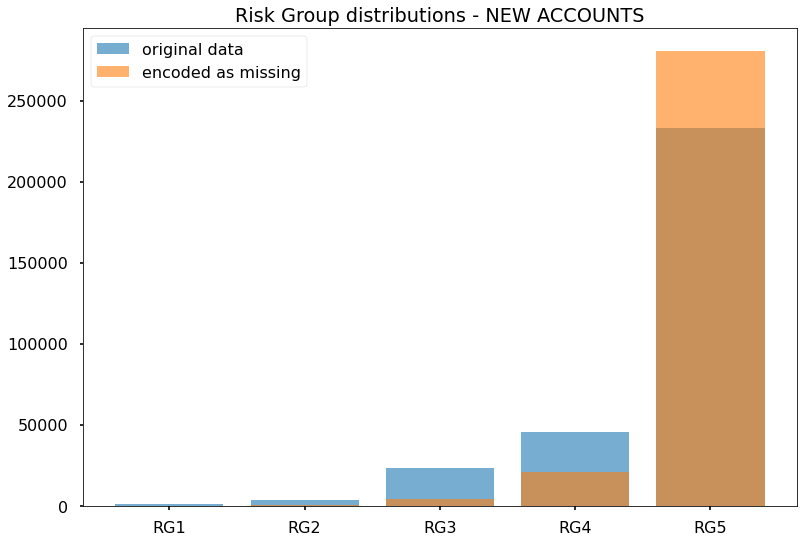

In [32]:
fig = plt.figure()
data = df_test_new.risk_group.value_counts().sort_index()
plt.bar(data.index, data.values, alpha=0.6, label='original data')
data = df_missing_new.risk_group.value_counts().sort_index()
plt.bar(data.index, data.values, alpha=0.6, label='encoded as missing')
plt.legend()
plt.title('Risk Group distributions - NEW ACCOUNTS')

Text(0.5, 1.0, 'Risk Group difference by encode credit features as missing')

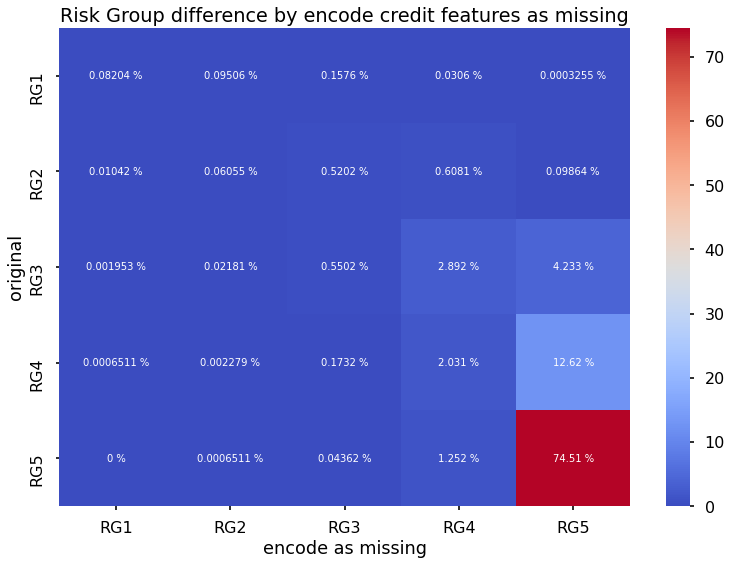

In [33]:
table = pd.merge(df_test_new[["business_account_number", "risk_group"]].astype(str),
                 df_missing_new[["business_account_number", "risk_group"]].astype(str),
                 on="business_account_number", suffixes=("_original", "_as_missing"),
                 how="inner")
table = table[["risk_group_original", "risk_group_as_missing"]].value_counts(normalize=True).sort_index().reset_index()

table.columns = ['original', 'encode as missing', 'counts']
table = pd.pivot_table(table, values='counts', index='original', 
                       columns='encode as missing', fill_value=0) * 100 # to percentage
fig = plt.figure()
ax = sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.4g')
for t in ax.texts: t.set_text(t.get_text() + " %")

plt.title('Risk Group difference by encode credit features as missing')

Text(0.5, 1.0, 'Risk Group difference by encode credit features as missing')

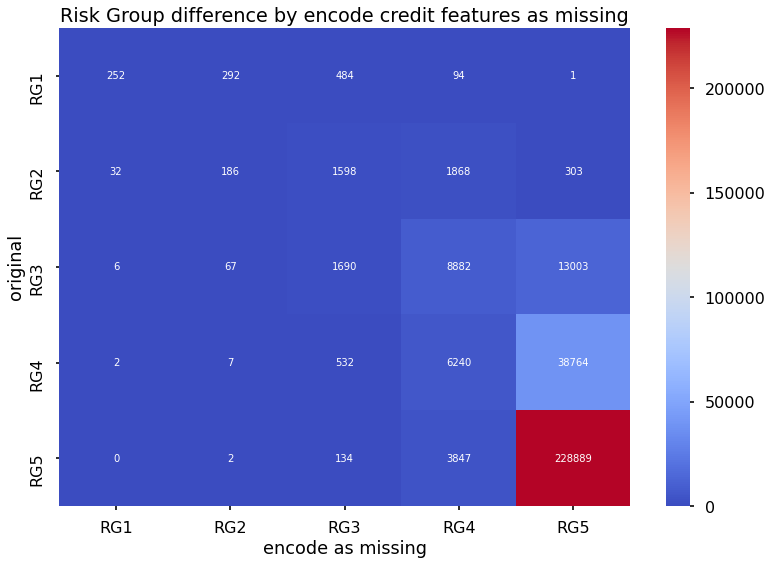

In [34]:
table = pd.merge(df_test_new[["business_account_number", "risk_group"]].astype(str),
                 df_missing_new[["business_account_number", "risk_group"]].astype(str),
                 on="business_account_number", suffixes=("_original", "_as_missing"),
                 how="inner")
table = table[["risk_group_original", "risk_group_as_missing"]].value_counts(normalize=False).sort_index().reset_index()

table.columns = ['original', 'encode as missing', 'counts']
table = pd.pivot_table(table, values='counts', index='original', 
                       columns='encode as missing', fill_value=0) 
fig = plt.figure()
ax = sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.6g')
# for t in ax.texts: t.set_text(t.get_text() + " %")

plt.title('Risk Group difference by encode credit features as missing')